### centrolign SV and horhap SV concordance finalized plots 

In [14]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [17]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


#### Get list of matched beds for each chrom 

In [10]:
import os
import csv

def parse_bed_files(folders):
    """
    Returns a dict:
      key = tuple(sorted([sample1, sample2]))
      value = full path to bed file
    Takes a list of folder paths and combines results.
    """
    beds = {}
    for folder in folders:
        for fname in os.listdir(folder):
            if not fname.endswith(".bed"):
                continue

            base = os.path.splitext(fname)[0]
            parts = base.split("_")
            if len(parts) != 2:
                continue

            key = tuple(sorted(parts))
            beds[key] = os.path.join(folder, fname)

    return beds


def match_beds(paths1, paths2, output_csv):
    beds1 = parse_bed_files(paths1)
    beds2 = parse_bed_files(paths2)

    all_keys = set(beds1) | set(beds2)

    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)

        for key in sorted(all_keys):
            bed1 = beds1.get(key)
            bed2 = beds2.get(key)
            if bed1 and bed2:
                writer.writerow([bed1, bed2])



In [11]:
## get list of horhap and centrolign beds matched by sample pair

### CHR12 
paths1=["/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chr12/SV_beds/chr12_subgroup0",
        "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chr12/SV_beds/chr12_subgroup1"]
paths2=["/private/groups/migalab/fryabov/HPRC/horhap_alignments/chr12/CV_bed/"]

output_csv = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr12/matched_beds.csv"
match_beds(paths1, paths2, output_csv)

### CHRX 
paths1=["/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chrX/SV_beds/chrX"]
paths2=["/private/groups/migalab/fryabov/HPRC/horhap_alignments/chrX/CV_bed"]

output_csv = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/matched_beds.csv"
match_beds(paths1, paths2, output_csv)

### CHR11 
paths1=["/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chr11/SV_beds/chr11_subgroupA",
       "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chr11/SV_beds/chr11_subgroupB",
       "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise_asm_coords/chr11/SV_beds/chr11_subgroupC"]
paths2=["/private/groups/migalab/fryabov/HPRC/horhap_alignments/chr11/CV_bed/"]

output_csv = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr11/matched_beds.csv"
match_beds(paths1, paths2, output_csv)

Ran `/private/groups/patenlab/mira/centrolign/github/centrolign_analysis/scripts/sv_comparev2.py` on slurm. 

#### Read in detailed performance log for all chroms

In [12]:
import pandas as pd
from pathlib import Path

def read_results(path):
    dfs = []

    for file in Path(path).glob("*_BED*_results.txt"):
        # Extract sample1 and sample2 from filename
        # Example: sampleA_sampleB_BED1_results.txt
        parts = file.stem.split("_")
        sample1, sample2 = parts[0], parts[1]

        # Read file
        df = pd.read_csv(file, sep="\t")

        # Add sample columns
        df["sample1"] = sample1
        df["sample2"] = sample2

        dfs.append(df)

    # Combine all files into one DataFrame
    return pd.concat(dfs, ignore_index=True)

In [13]:
errors_df = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr12/sv_compare2/md3k_msf0.5/")
errors_df2 = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chrX/sv_compare2/md4.5k_msf0.5/")
errors_df3 = read_results("/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/f1_scores/chr11/sv_compare2/md2.5k_msf0.5/")

errors_df["chr"]="chr12"
errors_df2["chr"]="chrX"
errors_df3["chr"]="chr11"
errors_df_all = pd.concat([errors_df, errors_df2,errors_df3], ignore_index=True)

Adjust labelling

In [15]:
df_incorrect = errors_df_all.copy()
df_incorrect.loc[df_incorrect["label"] == "BED1", "label"] = "Centrolign Only"
df_incorrect.loc[df_incorrect["label"] == "BED2", "label"] = "HORHAP Only"
df_incorrect.loc[df_incorrect["reason"] == "best subset size fraction failed min_size_frac", "reason"] = "SVs in window failed size threshold"
df_incorrect.loc[df_incorrect["reason"] == "no SVs overlap expanded window", "reason"] = "No SVs in expanded window"

len(df_incorrect)

9691229

Filter to pairs < 0.2

In [18]:
# Step 1: define sorted pair function
def make_sorted_pair(df):
    df = df.copy()
    df["sample_pair"] = df.apply(
        lambda row: tuple(sorted([row["sample1"], row["sample2"]])),
        axis=1
    )
    return df

# Step 2: create sample_pair columns
df_incorrect_pair = make_sorted_pair(df_incorrect)
all_pairs_dist_pair = make_sorted_pair(all_pairs_dist_df)

# Step 3: merge on sample_pair and chromosome
# Make sure the chromosome column names match; adjust if necessary
merged_df = df_incorrect_pair.merge(
    all_pairs_dist_pair,
    on=["sample_pair", "chr"],  # replace "chr" with your chromosome column name if different
    how="inner"  # can use "left" if you want to keep all incorrect SVs
)

# Step 4: drop temporary sample_pair column
merged_df = merged_df.drop(columns=["sample_pair"])

# Step 5: subset to direct_pairwise_dist < 0.2
df_filtered = merged_df[merged_df["direct_pairwise_dist"] < 0.2]

### Plot performance stratified by size

/data/tmp/ipykernel_1372986/1218172828.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sample_pair'] = df_filtered.apply(
/data/tmp/ipykernel_1372986/1218172828.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)
/data/tmp/ipykernel_1372986/1218172828.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

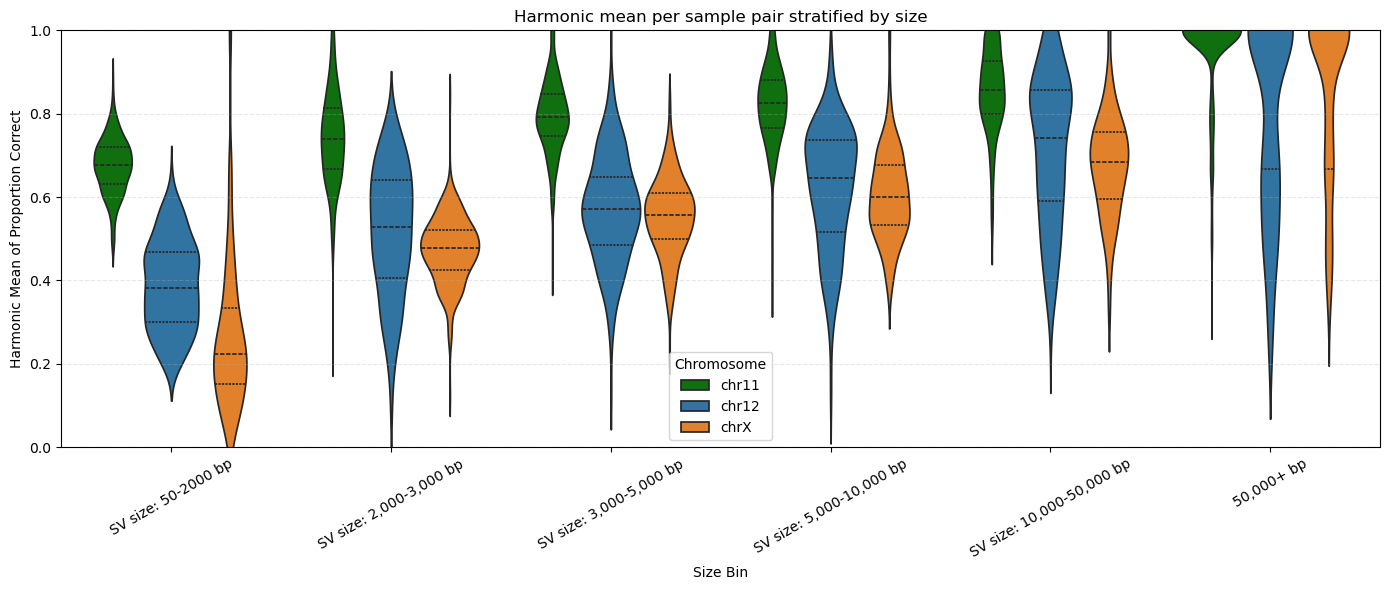

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure sample_pair exists
df_filtered['sample_pair'] = df_filtered.apply(
    lambda r: '_'.join(sorted([str(r['sample1_x']), str(r['sample2_x'])])),
    axis=1
)

# Define bins and labels
bins = [-float('inf'), 2000, 3000,5000 ,10000, 50000 ,float('inf')]
labels = ['SV size: 50-2000 bp', 'SV size: 2,000-3,000 bp', 'SV size: 3,000-5,000 bp', 'SV size: 5,000-10,000 bp',
          'SV size: 10,000-50,000 bp', '50,000+ bp']


df_filtered['size_bin'] = pd.cut(df_filtered['size'], bins=bins, labels=labels)

# Compute proportion correct per row
df_filtered['prop_correct'] = (df_filtered['matched'] == 'correct').astype(float)

# Harmonic mean function
def harmonic_mean(vals):
    vals = np.array(vals)
    vals = vals[vals > 0]  # ignore zeros
    if len(vals) == 0:
        return np.nan
    return len(vals) / np.sum(1.0 / vals)

# Pivot to get Centrolign and HorHap per row
pair_wide = df_filtered.pivot_table(
    index=['chr', 'size_bin', 'sample_pair'],
    columns='label',
    values='prop_correct',
    aggfunc='mean'   # average over multiple rows if needed
).reset_index()

# Remove groups missing either label
pair_wide = pair_wide.dropna(subset=['Centrolign Only', 'HORHAP Only'])

# Compute harmonic mean of Centrolign and HorHap for each sample pair
pair_wide['harmonic_mean_ratio'] = pair_wide.apply(
    lambda r: harmonic_mean([r['Centrolign Only'], r['HORHAP Only']]),
    axis=1
)

# --- Violin plot ---
chr_order = ['chr11','chr12','chrX']
size_order = labels

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=pair_wide,
    x='size_bin',
    y='harmonic_mean_ratio',
    hue='chr',
    order=size_order,
    hue_order=chr_order,
    palette={'chrX': 'tab:orange', 'chr12': 'tab:blue', 'chr11':'green'},
    split=False,
    inner='quartile'
)

plt.xlabel("Size Bin")
plt.ylabel("Harmonic Mean of Proportion Correct")
plt.title("Harmonic mean per sample pair stratified by size")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Chromosome')
plt.tight_layout()
plt.show()

